In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!unzip "drive/MyDrive/dog-breed-identification.zip" -d "drive/MyDrive/Colab Notebooks"

Archive:  drive/MyDrive/dog-breed-identification.zip
replace drive/MyDrive/Colab Notebooks/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 🐕 End to end multil-class dog breed classification
    This nodebook builds an image classifier using tenserflow 2.0 and Tenserflow hub.

  ### 1. problem
    Identify the breed of the dog given an image of a dog.

  ### 2. data
    The data we are using is from kaggle's dog breed identification competition.

  ### 3. evaluation
    The evaluation is a file with prediction probablities for  each dog breed for each test image.

  ### 4. features
    Info of the data:
    * we're dealing with images (unstructured data) so it's probably best we use deep learning/transferlearning.
    * There are 120 breeds of dogs (this means there are 120 different classes).
    * there are around 10000+ images in training set (these image does not have lebels)
    * there are around 10000+ images in test set (these images does not have lebels , because we'll want to predict them).

## Get our workspace ready

 * Import Tensorflow 2.x
 * Import Tensorflow Hub
 * make sure you are using GPU

In [5]:
#import tenserflow into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version : ", tf.__version__)
print("TF Hub version : ", hub.__version__)

#check for GPU availability
print("GPU", "available (YESSSSSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :( ")

TF version :  2.13.0
TF Hub version :  0.14.0
GPU available (YESSSSSS!!!!)


## getting data ready (turning into tensors)

In [8]:
# checkout labels of the data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Colab Notebooks/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [9]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

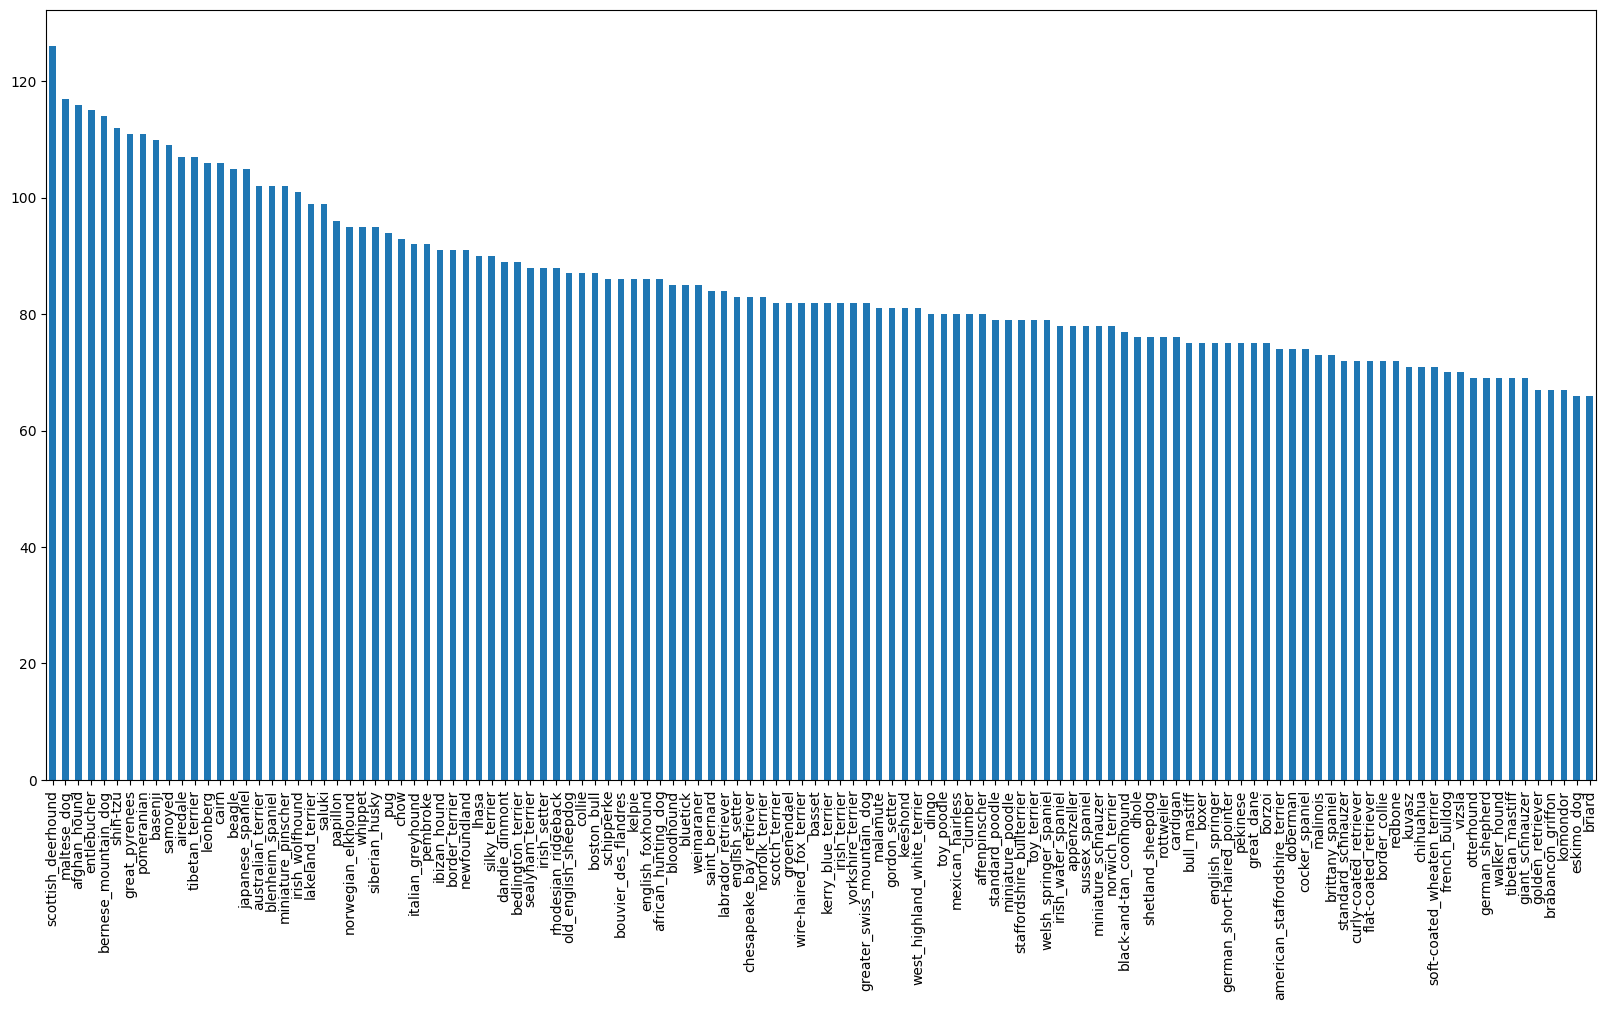

In [10]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [11]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

## Getting images their labels
  Let's get a list of our image file pathnames

In [14]:
# create path names from image IDs
filenames = ["drive/MyDrive/Colab Notebooks/train/"+fname for fname in labels_csv["id"]+".jpg" ]

# check the first 10
filenames[:10]

['drive/MyDrive/Colab Notebooks/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab Notebooks/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab Notebooks/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab Notebooks/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab Notebooks/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Colab Notebooks/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Colab Notebooks/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Colab Notebooks/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Colab Notebooks/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Colab Notebooks/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [15]:
# check wether number of filesnames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Colab Notebooks/train")) == len(filenames):
  print("Filenames match actual ammount of the files!!! proceed.")
else:
  print("Filenames do not match actual ammount of files, check the target dir.")

Filenames match actual ammount of the files!!! proceed.


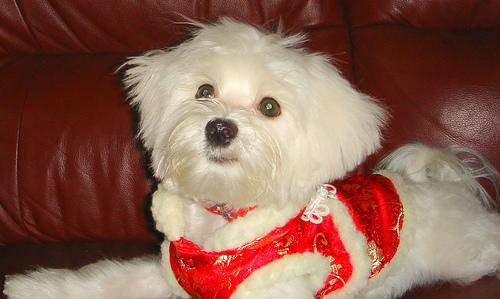

In [16]:
# lets view an image
from IPython.display import Image
Image(filenames[12])

In [17]:
labels_csv["breed"][12]

'maltese_dog'

Since we got our training image filepaths in a list , lets prepare our labels

In [27]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) # does same thing as above
labels , len(labels)

(array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
        'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object),
 10222)

In [19]:
# see if no. of labels matches with no. of filenames
if len(labels)== len(filenames):
  print("matched")
else:
  print("didnt match. check dir")

matched


In [21]:
# find unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [22]:
len(unique_breeds)

120

In [32]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [34]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [35]:
len(boolean_labels)

10222

In [36]:
# Example turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds==labels[0])) # index where label occurs
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validation set
Since the dataset from kaggle doesn't have validation set , we're going to create our own

In [37]:
# setup x and y
x = filenames
y = boolean_labels


we're going to start off experimenting with ~1000 images and increase as needed

In [38]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [39]:
# lets split our data into train and validation sets
from sklearn.model_selection import train_test_split

#slipt them into training and validation set of size num_images
x_train , x_val , y_train , y_val = train_test_split(x[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2 , random_state=42 )
len(x_train) , len(y_train) , len(x_val) , len(y_val)

(800, 800, 200, 200)

## preprocessing images and turning images into Tensors
 To process our images into tensors we're going to write
 1. Take an image filepath as input
 2. Use TensorFlow to read the file and save it to a variable , 'Image'
 3. Turn our Image (jpg) into Tensors
 4. Normalize our image (convert color channel values from 0-255 to 0-1)
 5. Resize the image to be a shape of (224 , 224)
 6. Return the modified image


In [40]:
# convert image into Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [47]:
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [42]:
image.max() , image.min()

(255, 0)

After seing how image looks like as a Tensor lets make a function to process them

In [49]:
# define image size
IMG_SIZE = 224

# create fxn for preprocessing images
def process_image(image_path , image_size=IMG_SIZE):
  """
  Take image file path and turn it into Tensor
  """
  # read in image file
  image = tf.io.read_file(image_path)

  # Turn jpeg image into numerical (looks like numpy array to me) Tensor with 3 color channels (red , green , blue)
  """For example, if you had a pixel with a value of 127 in the original tf.uint8 image tensor,
     after conversion, it would have a value of approximately 0.49804 in the tf.float32 image tensor (127 / 255 ≈ 0.49804).
  """
  image = tf.image.decode_jpeg(image , channels=3)

  # conver the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # resize the image to our desired value (224 , 224)
  image = tf.image.resize(image, size=[IMG_SIZE , IMG_SIZE])

  return image

In [ ]:
#tensor = tf.io.read_file(filenames[26])
#tensor

In [ ]:
#tf.image.decode_jpeg(tensor , channels=3)

In [ ]:
#tf.image.convert_image_dtype(tensor , tf.float32)

### Turning our data into batches
 * why turn our data into batches?
 >Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.
  So thats why we do about 32 (this is batch size) images at a time (you can manually adjust the batch size if need be).

  In order to use Tensorflow effectively , we need our data in the form of tensor tuples which look like this:
  `(image, label)`

In [50]:
# create a simple fxn to return a tuple (image , label)
def get_image_label(image_path , label):
  """
  takes an image filepath name and the associated label,
  processes the image and returns a type of (image , label).
  """

  image = process_image(image_path)
  return image , label

In [51]:
# demo of the above
process_image(x[42])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

Now we've got a way to turn our data into touples of Tensors in the form (image , label) , lets make a fxn to turn our data (x and y ) into branches

In [53]:
# define back size
BATCH_SIZE = 32

# create a fxn to turn data into branches
def create_data_batches(x ,y=None, batch_size=BATCH_SIZE , valid_data=False , test_data=False):
  """
  Creates batches of the data of image X and labels Y pairs.
  Shuffles the data if its training data but doesnt shuffle if its validation data.
  Also accepts test data as input (no labels).
  """

  if test_data: # test dataset doesnt have labels
    print("createing test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)   #mapping data in a TensorFlow dataset pipeline is a fundamental step in data preprocessing. It ensures consistency, efficiency, and flexibility in preparing data for machine learning models and other data-driven tasks.
    return data_batch

  elif valid_data: # valid data set doesnt need to be shuffeled
    print("createing valid data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x) , tf.constant(y))) #(filepath and labels)
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("createing training data batches")

    #turn filepath and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x) , tf.constant(y)))

    #shuffling pathnames and labels befor mapping image processor fxn is faster than
    data = data.shuffle(buffer_size=len(x))

    data= data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)
  return data_batch



In [54]:
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val , y_val , valid_data=True )

createing training data batches
createing valid data batches


In [55]:
# check out different attributes of our data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualising data Batches
Data is now in batches , but its hard to understand so lets visualise it

In [56]:
import matplotlib.pyplot as plt

# create a function for viewing images in the data batch
def show_25_images(images , labels):
  """
  Display a plot of 25 images and their labels from a data batch
  """
  #setup
  plt.figure(figsize=(10,10))

  #loop through 25 (dispaly 25 images)
  for i in range(25):
    # create subplots
    ax = plt.subplot(5,5 , i+1);

    #display image
    plt.imshow(images[i])

    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off") #turning off grid lines

In [57]:
train_images , train_labels = next(train_data.as_numpy_iterator())
train_images , train_labels

(array([[[[0.8530099 , 0.93144125, 0.9745785 ],
          [0.8715369 , 0.94991434, 0.9859115 ],
          [0.76305676, 0.8345927 , 0.87580305],
          ...,
          [0.40656203, 0.36909202, 0.2409496 ],
          [0.28991485, 0.26300526, 0.15008396],
          [0.27100295, 0.2540995 , 0.15192954]],
 
         [[0.8892427 , 0.9565046 , 0.99351513],
          [0.89845973, 0.965715  , 0.9982342 ],
          [0.876427  , 0.9362554 , 0.97442245],
          ...,
          [0.43340027, 0.35425472, 0.38647306],
          [0.517309  , 0.45677012, 0.49572086],
          [0.56881106, 0.51829463, 0.5747186 ]],
 
         [[0.92688435, 0.97337884, 0.9902416 ],
          [0.92496336, 0.9750019 , 0.9924142 ],
          [0.85173887, 0.90187305, 0.93573457],
          ...,
          [0.65455705, 0.56919914, 0.53906095],
          [0.664219  , 0.59683824, 0.56969887],
          [0.7450967 , 0.688873  , 0.6796646 ]],
 
         ...,
 
         [[0.22396943, 0.227891  , 0.20828316],
          [0.18997

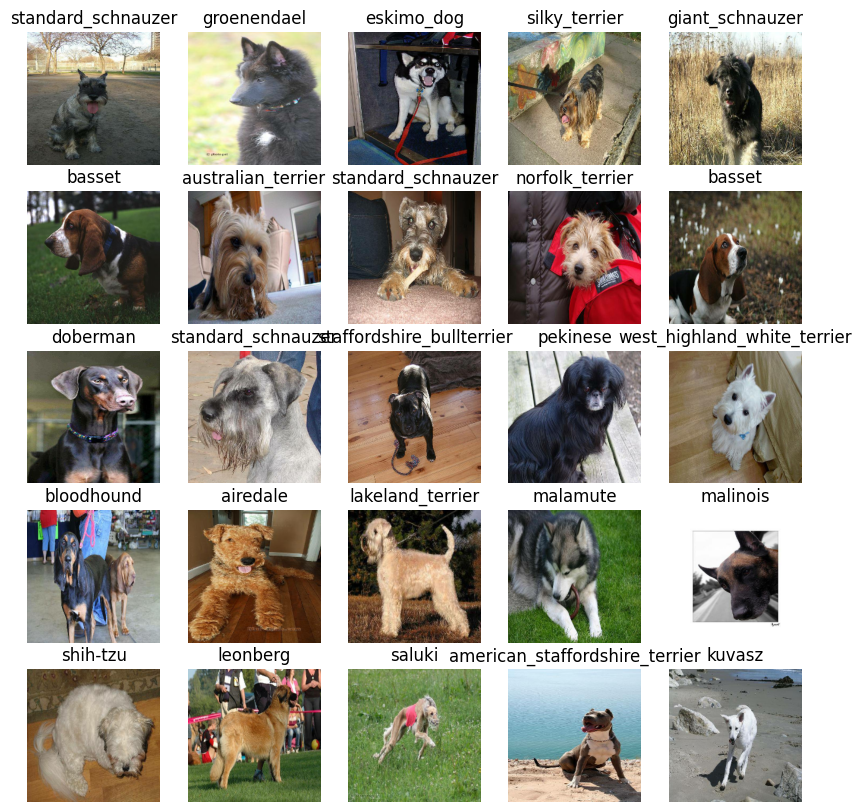

In [58]:

# now lets visualise data in training data in a training batch
show_25_images(train_images , train_labels)

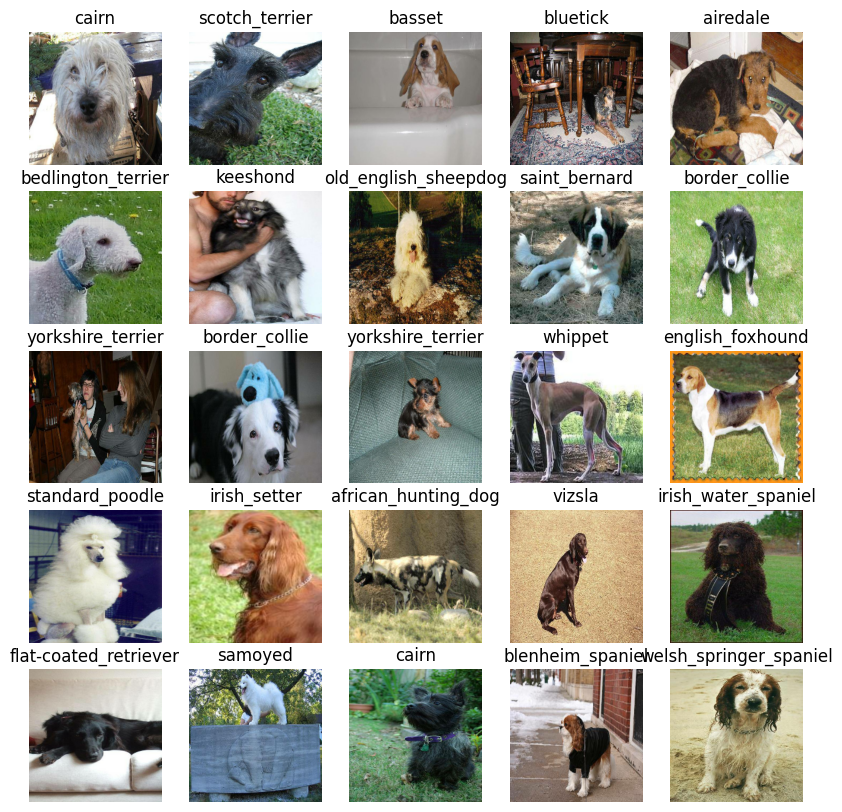

In [ ]:
val_image , val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_image , val_labels)

## Building The Model
Befor we build a model , there are a few things we need to define
* Input shape (images shape , in the form of Tensors) to our model.
* The output shape (image labels , in the form of tensors)
* The url of the model we want to use from tensorflow hub

In [59]:
IMG_SIZE

224

In [62]:
# setup input shape to model
INPUT_SHAPE = [None , IMG_SIZE , IMG_SIZE , 3] # batch , height , width , colour channels

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"


Lets put them into our Keras deep learning model

Knowing this , lets create a function which:
  * Takes the input shape , output shape and the model we've chosen as parameters.
  * Defines the layers in a keras model in sequential fashion (do this first , then this , then that)
  * Complies the model (says it should be evaluated and improved)
  * Builds the model (tells the model the input shape it'll be getting).
  * Returns the model

All of these steps can be found tensorflow.org/keras

In [63]:
# function that builds the keras model
def create_model(input_shape=INPUT_SHAPE , output_shape=OUTPUT_SHAPE , model_url = MODEL_URL):
  print("Building the model with : ",MODEL_URL )

  #setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL) , # layer 1 (input layer)

      tf.keras.layers.Dense(units=OUTPUT_SHAPE , activation="softmax") # layer 2 (output layer)
  ])

  # compile the model
  model.compile( loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"]
               )

  # Bild the model
  model.build(INPUT_SHAPE)
  return model


In [64]:
model = create_model()
model.summary()

Building the model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


##Creating Callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks , one for Tensorboard which helps track our models progress and another for early stopping which prevents our model from training for too long.

##Tensorboard Callback
To setup a tensorboard callback , we need to do 3 things:
* load the tensorboard
* Create a tensorboard callback which is able to save logs to a dir and pass it to the model's fit() fxn.
* Visualise our models training logs with the `%tensorboard` magic fxn (after model training)

In [67]:
# load TensorBoard notebook Extention
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [68]:
import datetime
#create a fxn to build a tensorboard call back
def create_tensorboard_callback():
  #create a log directory for storing tensorboard logs
  logdir =os.path.join("drive/MyDrive/Colab Notebooks/logs",
                        #make it so that logs get traced whenever we ran an experiment
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping Callback
Early stropping stopis our model from overfitting if certain evaluation metric stop improving

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [69]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy" , patience=3)

## Training a model (on subset of the data)
Our first model is only going to train on 1000 images so that we can make sure its working



In [70]:
NUM_EPOCHS = 100 #@param {type:"slider" , min:10, max:100 , step:10}

In [71]:
# make sure we are on a gpu
print("GPU", "available (YESSSSS!!)" if tf.config.list_physical_devices("GPU") else "Not available :(")

GPU available (YESSSSS!!)


Lets create a fxn which train model
* Creatre a model using `create_model()`
* Setup the `fit()` fxn on our model passing it the training data , validation data , number of epochs to train and the callbacks we'd like to use
* Return the model

In [73]:
def train_model():
  """
  Trains a given model and return the trained version.
  """
  # create model
  model = create_model()

  # create new tensorboard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # fit the model to the data passing it the callabcks we created
  model.fit(x=train_data , epochs=NUM_EPOCHS , validation_data=val_data , validation_freq=1 , callbacks=[tensorboard , early_stopping])

  return model

In [75]:
# fit the model to the data
model = train_model()


Building the model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 129s 5s/step - loss: 4.5193 - accuracy: 0.1250 - val_loss: 3.4697 - val_accuracy: 0.2700
Epoch 2/100
25/25 [==============================] - 3s 113ms/step - loss: 1.6023 - accuracy: 0.6875 - val_loss: 2.2276 - val_accuracy: 0.4850
Epoch 3/100
25/25 [==============================] - 3s 115ms/step - loss: 0.5715 - accuracy: 0.9375 - val_loss: 1.7286 - val_accuracy: 0.5500
Epoch 4/100
25/25 [==============================] - 4s 145ms/step - loss: 0.2563 - accuracy: 0.9850 - val_loss: 1.5305 - val_accuracy: 0.6050
Epoch 5/100
25/25 [==============================] - 3s 117ms/step - loss: 0.1427 - accuracy: 0.9975 - val_loss: 1.4640 - val_accuracy: 0.6050
Epoch 6/100
25/25 [==============================] - 3s 113ms/step - loss: 0.0980 - accuracy: 0.9987 - val_loss: 1.4288 - val_accuracy: 0.6200
Epoch 7/100
25/25 [=========================

## Making and evaluating predictions using a trained model


In [78]:
# make predictions on validation data
predictions = model.predict(val_data , verbose=1)
predictions

7/7 [==============================] - 32s 77ms/step


array([[3.7806318e-04, 1.3887364e-04, 1.2223287e-03, ..., 3.3381968e-04,
        2.9348244e-05, 4.0197838e-04],
       [2.1105492e-03, 6.1300606e-04, 2.3518369e-02, ..., 3.3125555e-04,
        8.1432139e-04, 1.3820108e-04],
       [9.2639493e-05, 2.5183504e-05, 2.1546057e-05, ..., 5.0845305e-05,
        1.5757885e-05, 1.2438244e-04],
       ...,
       [1.6306107e-05, 2.7763903e-05, 6.5096820e-06, ..., 2.0357575e-05,
        6.0742445e-06, 6.1704093e-05],
       [6.4132060e-03, 3.2739430e-05, 1.0571936e-04, ..., 8.4859712e-05,
        3.0108728e-05, 9.5565515e-03],
       [1.1836305e-04, 5.7350884e-05, 3.4505615e-04, ..., 2.4860790e-03,
        1.1374638e-03, 2.1032650e-04]], dtype=float32)

In [79]:
predictions.shape

(200, 120)

In [80]:
len(y_val) , len(unique_breeds)

(200, 120)

In [81]:
# first predictions
index=137
print(predictions[0])
print(f"max value (probablility of predictons): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[3.7806318e-04 1.3887364e-04 1.2223287e-03 2.8701303e-05 2.0232461e-04
 1.3117143e-06 9.4968276e-03 1.0441925e-03 8.0337268e-05 6.8259716e-04
 9.3942414e-05 1.4681583e-04 5.6076457e-04 4.5467241e-05 1.4465068e-04
 1.7476495e-04 3.7248021e-05 1.4641398e-01 9.8824867e-06 2.3048995e-05
 1.9117550e-04 1.6670367e-04 1.3805118e-05 3.2241194e-04 4.5418878e-05
 4.2084788e-04 5.4876149e-01 2.9876156e-04 2.4856086e-05 6.0744896e-05
 2.8119943e-04 1.5850274e-03 9.6151442e-04 3.7848880e-05 4.0436127e-05
 1.3029464e-02 3.1796939e-05 1.2862209e-04 4.2195865e-05 4.0764346e-05
 1.0302787e-03 1.0121175e-05 6.0820948e-05 1.5634860e-04 5.1447780e-05
 6.8124360e-04 1.6584985e-05 3.6209117e-04 1.4002627e-04 9.9846424e-05
 3.3832046e-05 3.5998074e-04 4.5798592e-05 3.7910911e-04 1.5441114e-04
 5.4471788e-05 1.2738610e-04 7.8470982e-04 1.3952758e-04 4.8233163e-02
 2.1839996e-04 3.1435517e-05 1.2715718e-03 3.4908186e-05 8.5481239e-05
 3.4644440e-02 1.6847052e-04 2.4551552e-04 8.8424236e-04 1.3952560e-04
 1.555

Having above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note** Prediction probabilities are also known as confidence labels

In [82]:
def get_pred_label(prediction_probabilities):
  """
  Turnan array of prediction probabilities into label.
  """

  return unique_breeds[np.argmax(prediction_probabilities)]

# get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since opur validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the valid labels(truth labels).

In [83]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [88]:
def unbatchify(data):
  """
  takes a batched dataset of (image , label) Tensors and returns seperate arrays of image and labels.
  """
  images=[]
  labels=[]

  for image , label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images , labels

# unbatchify validation data
val_images , val_labels = unbatchify(val_data)

In [90]:
val_images[0] , val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [91]:
get_pred_label(val_labels[0])

'affenpinscher'

 Now we've got ways to get :
 * prediction labels
 * Validation labels
 * validation images

 Lets make some function to make these all bit more visualise.  

 we'll create a function which:
 * Take an array of prediction probablities, an array of truth labels and an array of truth labels and an array of images and integers.
 * Conver the prediction probabilities to predicted label.
 * Plot the predicted label , its prdicted probability, the truth label and the target image on te single plot

In [92]:
def plot_pred(prediction_probabilities , labels , images , n=1):
  """
  View the prediction , ground truth and the image for sample n
  """
  pred_prob , true_label , image = prediction_probabilities[n] , labels[n] , images[n]

  # get pred label
  pred_label = get_pred_label(pred_prob)

  # plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #change the color of the title depending on if the prediction is write or wrong
  if pred_label == true_label:
    colour = "green"
  else:
    colour = "red"

  # change plot title to be predicted , probability of the prediction and the truth label
  plt.title("{} {:2.0f}% {}".format(pred_label , np.max(pred_prob)*100 , true_label) , color=colour)


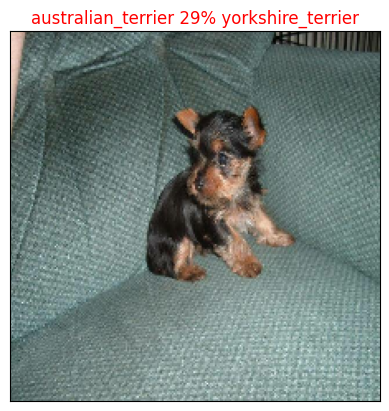

In [93]:
plot_pred(prediction_probabilities=predictions , labels = val_labels , images = val_images , n=12);

## Saving and reloding a model



In [94]:
# create a fxn to save model
def save_model(model , suffix=None):
  """
  Saves a given  model in a models directory and appends a suffix (string)
  """

  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Colab Notebooks/models" , datetime.datetime.now().strftime("%Y%m%d-%H%m%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model

  print(f"Saving model to: {model_path}..")
  model.save(model_path)

  return model_path

In [95]:
#create function to load a trained model
def load_model(model_path):
  """
  loads a saved model from a specified path.
  """
  print(f"loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path , custom_objects={"KerasLayer": hub.KerasLayer})

  return model

In [96]:
# save our model trained on 1000 images
save_model(model , suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Colab Notebooks/models/20230911-08091694422468-1000-images-mobilenetv2-Adam.h5..


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Colab Notebooks/models/20230911-08091694422468-1000-images-mobilenetv2-Adam.h5'

In [97]:
# load a rmodel
loaded_1000_image_model = load_model("drive/MyDrive/Colab Notebooks/models/20230805-09081691226965-1000-images-mobilenetv2-Adam.h5")

loading saved model from: drive/MyDrive/Colab Notebooks/models/20230805-09081691226965-1000-images-mobilenetv2-Adam.h5


In [98]:
model.evaluate(val_data)

7/7 [==============================] - 1s 93ms/step - loss: 1.3066 - accuracy: 0.6400


[1.3065598011016846, 0.6399999856948853]

In [99]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 83ms/step - loss: 1.3230 - accuracy: 0.6500


[1.3229613304138184, 0.6499999761581421]

## Training a Big dog model


In [100]:
len(x) , len(y)

(10222, 10222)

In [101]:
# create databatch with full data set
full_data = create_data_batches(x,y)

createing training data batches


In [102]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [103]:
# create a model for full model
full_model = create_model()

Building the model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [104]:

# create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training full data , so we cant monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

Running below cell will take a little while (maybe 30 min for the first epoch) because the gpu we're using is the runtime has to load all of the images into memory.

In [105]:
# fit the full model to the full data
full_model.fit(x=full_data , epochs=NUM_EPOCHS , callbacks=[full_model_tensorboard , full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1682s 5s/step - loss: 1.3437 - accuracy: 0.6647
Epoch 2/100
320/320 [==============================] - 31s 98ms/step - loss: 0.4036 - accuracy: 0.8800
Epoch 3/100
320/320 [==============================] - 31s 98ms/step - loss: 0.2342 - accuracy: 0.9351
Epoch 4/100
320/320 [==============================] - 31s 97ms/step - loss: 0.1537 - accuracy: 0.9626
Epoch 5/100
320/320 [==============================] - 31s 98ms/step - loss: 0.1044 - accuracy: 0.9802
Epoch 6/100
320/320 [==============================] - 31s 98ms/step - loss: 0.0782 - accuracy: 0.9855
Epoch 7/100
320/320 [==============================] - 31s 97ms/step - loss: 0.0585 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 32s 100ms/step - loss: 0.0465 - accuracy: 0.9942
Epoch 9/100
320/320 [==============================] - 32s 99ms/step - loss: 0.0379 - accuracy: 0.9947
Epoch 10/100
320/320 [==============================] - 33s 103ms/step -

In [106]:

save_model(full_model , suffix="full-image-set-mobilenetv2-adam")

Saving model to: drive/MyDrive/Colab Notebooks/models/20230911-09091694424770-full-image-set-mobilenetv2-adam.h5..


'drive/MyDrive/Colab Notebooks/models/20230911-09091694424770-full-image-set-mobilenetv2-adam.h5'

In [108]:
loaded_full_model = load_model('drive/MyDrive/Colab Notebooks/models/20230911-09091694424770-full-image-set-mobilenetv2-adam.h5')

loading saved model from: drive/MyDrive/Colab Notebooks/models/20230911-09091694424770-full-image-set-mobilenetv2-adam.h5


## Making predictions on the test dataset
Since our model has been trained on images in the form of tensors batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we have created `create_data_batches()` earlier which can take list of filenames as input ans cover them into tensor batches.

To make predictions on the test data, we'll:
* get the test image filenames
* convert filenames into test data batches using create_data_batches() and setting the test_data parameter to true(since test data doesn't have labels)
* Make predictions array by passing the test batches to the `predict()` method called on our model

In [109]:
# load test image files
test_path = "drive/MyDrive/Colab Notebooks/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Colab Notebooks/test/e487437a727b3e4f0b919c878d39ae6e.jpg',
 'drive/MyDrive/Colab Notebooks/test/e39be68f3200f0ecde589e571ae6df06.jpg',
 'drive/MyDrive/Colab Notebooks/test/e63a126acd70223f2d388702843d185b.jpg',
 'drive/MyDrive/Colab Notebooks/test/e745d75a74a9cbdc917e7775febd88e8.jpg',
 'drive/MyDrive/Colab Notebooks/test/e5ded7a736b3336729463af8d74a09c9.jpg',
 'drive/MyDrive/Colab Notebooks/test/e53cb5b42ea1a7700cd294a336890361.jpg',
 'drive/MyDrive/Colab Notebooks/test/e0ccfbe350e0e8bc7bb7e1f95fa07b3b.jpg',
 'drive/MyDrive/Colab Notebooks/test/e427b9e1ab1b7f09cfb02ac073f56f2d.jpg',
 'drive/MyDrive/Colab Notebooks/test/e4235f4b313a4b49946938992dd95249.jpg',
 'drive/MyDrive/Colab Notebooks/test/e7e9624f2a2e61ab187358f5968bfde8.jpg']

In [110]:
test_data = create_data_batches(test_filenames , test_data=True)

createing test data batches


In [111]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note** : calling predict() on our full mdoel and passing it in the test data batch will take a long time to run (about an hour)

In [112]:
# make predictions on the test data batches using the loaded full model
test_pred = loaded_full_model.predict(test_data , verbose=1)


324/324 [==============================] - 209s 626ms/step


In [113]:
# save predictions to csv file (for leter)
np.savetxt("drive/MyDrive/Colab Notebooks/preds_array.csv",test_pred , delimiter=",")

In [114]:
test_pred =np.loadtxt("drive/MyDrive/Colab Notebooks/preds_array.csv",delimiter=",")

In [115]:
test_pred[:10]

array([[9.99968767e-01, 1.20674044e-11, 4.11113060e-10, ...,
        2.66062644e-13, 3.95348891e-08, 3.42246148e-10],
       [1.14763191e-06, 2.39024089e-09, 7.96684247e-08, ...,
        1.65216271e-10, 3.25839551e-06, 5.56556799e-04],
       [6.89546900e-12, 4.08997369e-09, 8.36529290e-10, ...,
        8.92007301e-10, 1.05766319e-10, 9.00447911e-11],
       ...,
       [1.02370352e-08, 3.60802375e-08, 2.81432683e-10, ...,
        5.91774796e-10, 9.99297619e-01, 2.27245511e-08],
       [1.98241112e-09, 2.12469514e-10, 1.83085494e-13, ...,
        7.09984155e-13, 4.15994741e-08, 1.83815132e-08],
       [3.72545621e-08, 2.42552223e-09, 1.01197104e-08, ...,
        6.48618226e-09, 5.62669022e-09, 3.03849368e-09]])

In [116]:
test_pred.shape

(10357, 120)

## preparing test dataset predictions for keggle

Looking at the keggle sample submission , we find that it wants p=our models predictions probabilities output in dataframe with an id and column for each different dog breed .

To get data in the format , we'll:
* create a pandas dataframe with an ID columns as well as a column for each dog breed .
* add data to the id column by extracting the test image ID's from their filepaths.
* add data (the prediction probabilities) to each of the dog breed columns.
* export the dataframe as csv to submit it to kaggle.

In [117]:
# create pandas dataframe with an empty column
preds_df = pd.DataFrame(columns=["id"]+list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [118]:
# append test image id's to prediction dataframe
test_ids = [os.path.splitext(path) for path in os.listdir(test_path)]

In [119]:
os.path.splitext(test_filenames[0])

('drive/MyDrive/Colab Notebooks/test/e487437a727b3e4f0b919c878d39ae6e', '.jpg')

In [120]:
preds_df["id"] = test_ids

In [121]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,"(e487437a727b3e4f0b919c878d39ae6e, .jpg)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(e39be68f3200f0ecde589e571ae6df06, .jpg)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(e63a126acd70223f2d388702843d185b, .jpg)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(e745d75a74a9cbdc917e7775febd88e8, .jpg)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(e5ded7a736b3336729463af8d74a09c9, .jpg)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
# add the prediction probabilities to each dog breeds column
preds_df[list(unique_breeds)] = test_pred

In [123]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,"(e487437a727b3e4f0b919c878d39ae6e, .jpg)",9.999688e-01,1.206740e-11,4.111131e-10,2.238474e-12,1.665920e-11,2.882053e-12,7.474737e-08,9.695988e-12,3.221770e-11,...,2.008150e-10,1.072960e-09,1.408799e-09,1.438297e-12,2.377777e-12,3.619607e-14,3.703715e-12,2.660626e-13,3.953489e-08,3.422461e-10
1,"(e39be68f3200f0ecde589e571ae6df06, .jpg)",1.147632e-06,2.390241e-09,7.966842e-08,4.568557e-11,1.677010e-09,1.523789e-07,2.613248e-08,1.818667e-08,1.444786e-09,...,5.206424e-06,1.073577e-05,2.099247e-08,3.099071e-09,2.239529e-09,3.023617e-09,1.358076e-06,1.652163e-10,3.258396e-06,5.565568e-04
2,"(e63a126acd70223f2d388702843d185b, .jpg)",6.895469e-12,4.089974e-09,8.365293e-10,9.360241e-09,2.438514e-10,1.171067e-07,1.428284e-12,4.541445e-11,1.430140e-07,...,4.436129e-09,1.659475e-10,3.392805e-08,9.796925e-08,3.644201e-11,3.359779e-06,6.925610e-09,8.920073e-10,1.057663e-10,9.004479e-11
3,"(e745d75a74a9cbdc917e7775febd88e8, .jpg)",9.644207e-12,2.081493e-12,3.434905e-13,4.428070e-10,8.991890e-07,1.980763e-06,4.144235e-07,7.565542e-07,6.112832e-09,...,2.652695e-07,1.628861e-08,3.555146e-05,8.034649e-06,8.416168e-10,5.962965e-09,7.260503e-11,4.073226e-10,3.789102e-11,1.195219e-12
4,"(e5ded7a736b3336729463af8d74a09c9, .jpg)",2.678839e-11,1.505901e-10,2.908657e-07,8.101078e-10,8.969102e-12,5.286064e-05,1.805167e-09,1.933808e-09,3.168187e-11,...,3.618061e-10,6.253611e-07,7.668875e-11,3.893922e-10,3.830607e-10,3.190769e-12,3.082222e-09,3.239567e-10,1.386312e-09,2.327511e-09


In [124]:
preds_df.to_csv("drive/MyDrive/Colab Notebooks/full_model_predictions_subbmission_1_mobilenetV2.csv", index=False)

## making prediction on custom images

to make predictions on custom images we'll :
* get the filepaths of our own images
* turn filepaths into databatches
* pass custom image data batch into our model's predict() method
* conver prediction output probabilities to prediction labels.
* compare the predicted labels to custom images.

In [125]:
custom_path = "drive/MyDrive/Colab Notebooks/My_Dog_Images/"
custom_image_path = [custom_path + fname for fname in os.listdir(custom_path)]

In [126]:
custom_image_path

['drive/MyDrive/Colab Notebooks/My_Dog_Images/Labradoodle-image-1.jpg',
 'drive/MyDrive/Colab Notebooks/My_Dog_Images/labradoodle (1).jpg',
 'drive/MyDrive/Colab Notebooks/My_Dog_Images/Labradoodle.jpg',
 'drive/MyDrive/Colab Notebooks/My_Dog_Images/petite-Labradoodle-puppy-on-grass_Danii-Brown-Photography_Shutterstock-760x507.jpg']

In [127]:
# turn custom image into custom batches
custom_data = create_data_batches(custom_image_path , test_data=True)
custom_data

createing test data batches


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [128]:
# make prediction on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 2s 2s/step


In [129]:
custom_preds

array([[1.46000021e-08, 9.93673093e-05, 1.83836779e-09, 2.96698854e-04,
        1.41189474e-07, 7.00802694e-10, 7.52317501e-05, 5.79920027e-07,
        5.93785354e-10, 9.49415302e-09, 2.32634161e-08, 2.42124543e-09,
        2.15941087e-09, 5.94284813e-07, 4.30448965e-09, 1.46389846e-06,
        1.52381062e-05, 2.76344781e-06, 1.96662148e-11, 1.75308901e-09,
        8.52393427e-08, 1.45081724e-08, 5.49800490e-08, 5.70668453e-05,
        1.45512263e-06, 4.17342153e-06, 8.17263981e-07, 5.43475664e-09,
        3.33471961e-09, 9.67831926e-10, 1.74378727e-06, 1.95256007e-06,
        4.42552619e-06, 6.75091427e-10, 5.56785285e-09, 3.10223870e-04,
        7.93735980e-11, 2.90006863e-09, 1.74788281e-10, 1.55598534e-09,
        1.08375708e-09, 5.14730081e-09, 2.85135793e-05, 2.92710723e-07,
        1.13110032e-09, 2.24643459e-09, 9.63882751e-09, 2.48034726e-09,
        3.30846751e-06, 2.59916487e-06, 5.32979243e-07, 4.21396095e-07,
        5.81404038e-07, 1.60232565e-04, 1.69565778e-10, 6.828586

In [130]:
custom_preds_labels =[get_pred_label(custom_preds[i])for i in range(len(custom_preds))]
custom_preds_labels

['miniature_poodle', 'miniature_poodle', 'otterhound', 'standard_poodle']

In [131]:
# get custom images
custom_images = []

for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

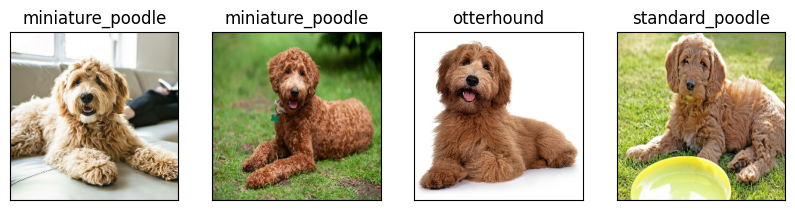

In [132]:
# check custom image predictions
plt.figure(figsize=(10,10))
for i , image in enumerate(custom_images):
  plt.subplot(1,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_preds_labels[i])
  plt.imshow(image)